##REading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv(r"C:\Users\Ram\Desktop\Math of data science\AswanData_weatherdata (1).csv")

In [3]:
# --- Data cleaning & feature engineering
# This cell performs: column cleanup, date parsing, deduplication, missing value handling,
# outlier capping, new feature creation, and saving a cleaned CSV.

# Remove any unnamed index-like column (e.g., 'Unnamed: 0') that came from CSV
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Rename columns for consistency
df = df.rename(columns={
    'AvgTemperture': 'AvgTemperature',
    'AverageDew(point via humidity)': 'AvgDew',
    'Solar(PV)': 'Solar_PV'
})

# Parse Date column
df['Date'] = pd.to_datetime(df['Date'], dayfirst=False, errors='coerce')

# Sort and drop duplicate dates (keep first measurement per date)
df = df.sort_values('Date').reset_index(drop=True)
df = df.drop_duplicates(subset=['Date'], keep='first')

# Quick diagnostics
print('Shape after dedup:', df.shape)
print('\nMissing values per column:\n', df.isnull().sum())

# Impute numeric missing values with median
num_cols = df.select_dtypes(include='number').columns.tolist()
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

# Cap outliers per column using IQR method
def cap_outliers(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return col.clip(lower, upper)

df[num_cols] = df[num_cols].apply(cap_outliers)

# Feature engineering
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['dayofweek'] = df['Date'].dt.dayofweek
df['is_weekend'] = df['dayofweek'] >= 5

df['temp_dew_diff'] = df['AvgTemperature'] - df['AvgDew']
df['solar_log'] = np.log1p(df['Solar_PV'])

df['temp_rolling_3'] = df['AvgTemperature'].rolling(window=3, min_periods=1).mean()
df['temp_lag_1'] = df['AvgTemperature'].shift(1).fillna(method='bfill')

# --- Classification / binning additions ---
# Create pressure categories (low/medium/high) using tertiles (qcut);
# fallback to cut if qcut fails due to insufficient unique values.
try:
    df['pressure_cat'] = pd.qcut(df['Pressure'], q=3, labels=['low','medium','high'])
except ValueError:
    try:
        df['pressure_cat'] = pd.cut(df['Pressure'], bins=3, labels=['low','medium','high'])
    except Exception:
        df['pressure_cat'] = 'normal'

# Create Solar_PV categories and a binary high-output flag
try:
    df['solar_bin'] = pd.qcut(df['Solar_PV'], q=3, labels=['low','medium','high'])
except ValueError:
    df['solar_bin'] = pd.cut(df['Solar_PV'], bins=3, labels=['low','medium','high'])

# Binary flag for high solar output (top 25%)
df['is_solar_high'] = df['Solar_PV'] > df['Solar_PV'].quantile(0.75)

# Save cleaned dataset
out_path = r"C:\Users\Ram\Desktop\Math of data science\AswanData_weatherdata_cleaned.csv"
df.to_csv(out_path, index=False)
print('\nCleaned data saved to:', out_path)

# Show the cleaned head and a brief summary
print('\nCleaned data sample:')
df.head(10)

Shape after dedup: (370, 7)

Missing values per column:
 Date              0
AvgTemperature    0
AvgDew            0
Humidity          0
Wind              0
Pressure          0
Solar_PV          0
dtype: int64

Cleaned data saved to: C:\Users\Ram\Desktop\Math of data science\AswanData_weatherdata_cleaned.csv

Cleaned data sample:


C:\Users\Ram\AppData\Local\Temp\ipykernel_11068\398477019.py:53: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['temp_lag_1'] = df['AvgTemperature'].shift(1).fillna(method='bfill')


,Date,AvgTemperature,AvgDew,Humidity,Wind,Pressure,Solar_PV,year,month,day,dayofweek,is_weekend,temp_dew_diff,solar_log,temp_rolling_3,temp_lag_1,pressure_cat,solar_bin,is_solar_high
0,2021-04-01,80.0,29.4,16.7,10.9,29.2,31.214857,2021,4,1,3,False,50.6,3.472428,80.000000,80.0,medium,high,False
1,2021-04-02,79.7,31.3,18.1,10.3,29.2,34.046000,2021,4,2,4,False,48.4,3.556661,79.850000,80.0,medium,high,True
2,2021-04-03,77.2,30.4,20.7,10.8,29.2,34.187143,2021,4,3,5,True,46.8,3.560681,78.966667,79.7,medium,high,True
3,2021-04-04,73.1,25.1,17.3,9.0,29.2,31.442286,2021,4,4,6,True,48.0,3.479463,76.666667,77.2,medium,high,False
4,2021-04-05,85.6,26.3,11.8,7.6,29.2,31.606571,2021,4,5,0,False,59.3,3.484514,78.633333,73.1,medium,high,False
5,2021-04-06,81.0,37.3,21.0,12.3,29.2,30.525429,2021,4,6,1,False,43.7,3.450794,79.900000,85.6,medium,high,False
6,2021-04-07,85.9,37.9,18.5,14.3,29.2,35.386857,2021,4,7,2,False,48.0,3.594208,84.166667,81.0,medium,high,True
7,2021-04-08,77.6,31.9,19.6,16.6,29.2,33.410286,2021,4,8,3,False,45.7,3.538356,81.500000,85.9,medium,high,True
8,2021-04-09,72.7,32.1,23.4,11.7,29.2,36.437143,2021,4,9,4,False,40.6,3.622663,78.733333,77.6,medium,high,True
9,2021-04-10,74.4,31.9,22.2,12.7,29.3,34.797429,2021,4,10,5,True,42.5,3.577876,74.900000,72.7,medium,high,True


In [4]:
# Verification: show columns and a small sample
print('Columns:', df.columns.tolist())
print('Shape:', df.shape)
df.head(5)

Columns: ['Date', 'AvgTemperature', 'AvgDew', 'Humidity', 'Wind', 'Pressure', 'Solar_PV', 'year', 'month', 'day', 'dayofweek', 'is_weekend', 'temp_dew_diff', 'solar_log', 'temp_rolling_3', 'temp_lag_1', 'pressure_cat', 'solar_bin', 'is_solar_high']
Shape: (370, 19)


,Date,AvgTemperature,AvgDew,Humidity,Wind,Pressure,Solar_PV,year,month,day,dayofweek,is_weekend,temp_dew_diff,solar_log,temp_rolling_3,temp_lag_1,pressure_cat,solar_bin,is_solar_high
0,2021-04-01,80.0,29.4,16.7,10.9,29.2,31.214857,2021,4,1,3,False,50.6,3.472428,80.000000,80.0,medium,high,False
1,2021-04-02,79.7,31.3,18.1,10.3,29.2,34.046000,2021,4,2,4,False,48.4,3.556661,79.850000,80.0,medium,high,True
2,2021-04-03,77.2,30.4,20.7,10.8,29.2,34.187143,2021,4,3,5,True,46.8,3.560681,78.966667,79.7,medium,high,True
3,2021-04-04,73.1,25.1,17.3,9.0,29.2,31.442286,2021,4,4,6,True,48.0,3.479463,76.666667,77.2,medium,high,False
4,2021-04-05,85.6,26.3,11.8,7.6,29.2,31.606571,2021,4,5,0,False,59.3,3.484514,78.633333,73.1,medium,high,False


In [5]:
df.head(20)

,Date,AvgTemperature,AvgDew,Humidity,Wind,Pressure,Solar_PV,year,month,day,dayofweek,is_weekend,temp_dew_diff,solar_log,temp_rolling_3,temp_lag_1,pressure_cat,solar_bin,is_solar_high
0,2021-04-01,80.0,29.4,16.7,10.9,29.2,31.214857,2021,4,1,3,False,50.6,3.472428,80.000000,80.0,medium,high,False
1,2021-04-02,79.7,31.3,18.1,10.3,29.2,34.046000,2021,4,2,4,False,48.4,3.556661,79.850000,80.0,medium,high,True
2,2021-04-03,77.2,30.4,20.7,10.8,29.2,34.187143,2021,4,3,5,True,46.8,3.560681,78.966667,79.7,medium,high,True
3,2021-04-04,73.1,25.1,17.3,9.0,29.2,31.442286,2021,4,4,6,True,48.0,3.479463,76.666667,77.2,medium,high,False
4,2021-04-05,85.6,26.3,11.8,7.6,29.2,31.606571,2021,4,5,0,False,59.3,3.484514,78.633333,73.1,medium,high,False
5,2021-04-06,81.0,37.3,21.0,12.3,29.2,30.525429,2021,4,6,1,False,43.7,3.450794,79.900000,85.6,medium,high,False
6,2021-04-07,85.9,37.9,18.5,14.3,29.2,35.386857,2021,4,7,2,False,48.0,3.594208,84.166667,81.0,medium,high,True
7,2021-04-08,77.6,31.9,19.6,16.6,29.2,33.410286,2021,4,8,3,False,45.7,3.538356,81.500000,85.9,medium,high,True
8,2021-04-09,72.7,32.1,23.4,11.7,29.2,36.437143,2021,4,9,4,False,40.6,3.622663,78.733333,77.6,medium,high,True
9,2021-04-10,74.4,31.9,22.2,12.7,29.3,34.797429,2021,4,10,5,True,42.5,3.577876,74.900000,72.7,medium,high,True


Regression features: ['AvgTemperature', 'Humidity', 'Wind', 'Pressure', 'temp_dew_diff', 'temp_rolling_3', 'temp_lag_1']
Regression shape: (370, 7)
Linear Regression — RMSE: 6.969
Linear Regression — R2 Score: 0.028
Model Accuracy (100 - MAPE): 73.10%
Threshold Accuracy (Predictions within ±20%): 39.19%

Top coefficients:
          feature      coef
4   temp_dew_diff  2.817129
2            Wind  1.586383
0  AvgTemperature -1.508483
3        Pressure  1.031639
1        Humidity -0.340010


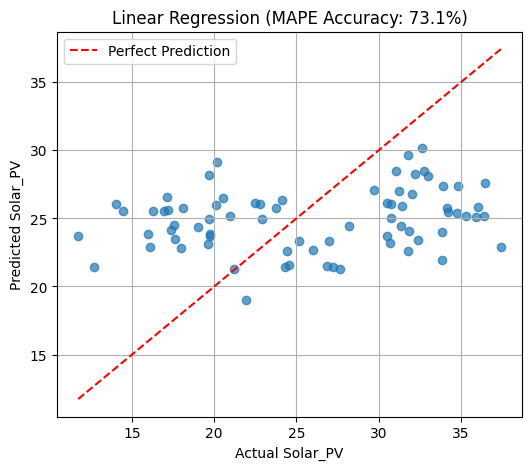

In [20]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

# ... (Previous imports and data splitting code remains the same) ...

# --- Linear Regression ---
print('Regression features:', features_reg)
print('Regression shape:', X_reg.shape)

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_s, y_train)
y_pred = lr.predict(X_test_s)

# --- STANDARD REGRESSION METRICS ---
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'Linear Regression — RMSE: {rmse:.3f}')
print(f'Linear Regression — R2 Score: {r2:.3f}')

# --- NEW: ACCURACY METRICS FOR REGRESSION ---

# 1. MAPE (Mean Absolute Percentage Error)
# Note: We add a tiny epsilon to y_test to avoid division by zero errors if Solar_PV is 0
mape = mean_absolute_percentage_error(y_test, y_pred)
accuracy_mape = 100 - (mape * 100)
print(f'Model Accuracy (100 - MAPE): {accuracy_mape:.2f}%')

# 2. Threshold Accuracy (e.g., % of predictions within +/- 20% of actual)
threshold = 0.20  # 20%
# Calculate absolute percent difference for every row
abs_percent_diff = np.abs((y_test - y_pred) / (y_test + 1e-6))
# Count how many are within the threshold
within_threshold = np.mean(abs_percent_diff < threshold)
print(f'Threshold Accuracy (Predictions within ±{int(threshold*100)}%): {within_threshold:.2%}')

# Coefficients
coef_df = pd.DataFrame({'feature': features_reg, 'coef': lr.coef_})
print('\nTop coefficients:')
print(coef_df.sort_values('coef', key=abs, ascending=False).head())

# Scatter plot: actual vs predicted
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Solar_PV')
plt.ylabel('Predicted Solar_PV')
plt.title(f'Linear Regression (MAPE Accuracy: {accuracy_mape:.1f}%)')
plt.legend()
plt.grid(True)
plt.show()

### Feature selection + focused logistic regression
This cell finds the most predictive numeric features (mutual information), trains a class-weighted multinomial LogisticRegression on the top features, and visualizes results (confusion matrix and coefficients). It prints accuracy, balanced accuracy and macro-F1.

--- Model Accuracy: 77.03% ---

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.98      0.86        55
           1       0.75      0.16      0.26        19

    accuracy                           0.77        74
   macro avg       0.76      0.57      0.56        74
weighted avg       0.77      0.77      0.71        74



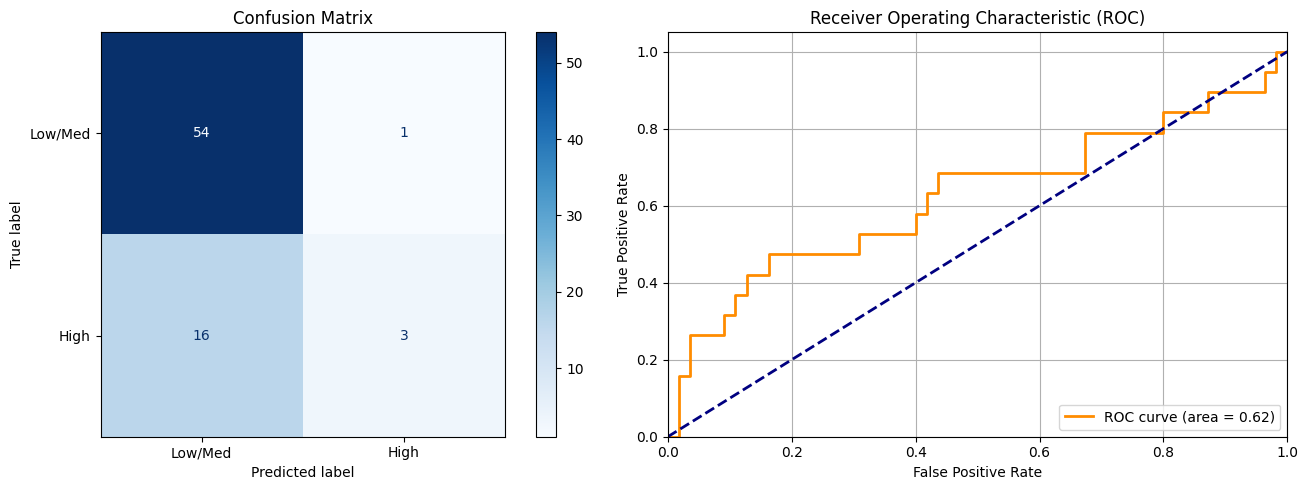


Feature Importance (Log Odds):
          Feature  Coefficient
0  AvgTemperature    -0.864036
5           svd_1     0.628234
4   temp_dew_diff     0.548646
1        Humidity    -0.413339
6           svd_2     0.392231
2            Wind     0.239093
3        Pressure     0.196608


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report

# 1. Define Features (X) and Target (y)
# We use weather features + the SVD components we created earlier.
# CRITICAL: We exclude 'Solar_PV', 'solar_log', and 'solar_bin' to prevent cheating (leakage).
feature_cols = ['AvgTemperature', 'Humidity', 'Wind', 'Pressure', 
                'temp_dew_diff', 'svd_1', 'svd_2']

X = df[feature_cols].copy()
y = df['is_solar_high'].astype(int) # Ensure target is 0/1

# 2. Split Data (Stratify ensures we keep the same % of High/Low days in train and test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Scale Data (Important for Logistic Regression)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# 4. Train Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_s, y_train)

# 5. Make Predictions
y_pred = log_reg.predict(X_test_s)
y_prob = log_reg.predict_proba(X_test_s)[:, 1] # Probability of being "High" (1)

# 6. Evaluation Metrics
acc = accuracy_score(y_test, y_pred)
print(f"--- Model Accuracy: {acc:.2%} ---\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 7. Plots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot A: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low/Med', 'High']).plot(ax=ax[0], cmap='Blues')
ax[0].set_title('Confusion Matrix')

# Plot B: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic (ROC)')
ax[1].legend(loc="lower right")
ax[1].grid(True)

plt.tight_layout()
plt.show()

# 8. Show which features mattered most
coefs = pd.DataFrame({'Feature': feature_cols, 'Coefficient': log_reg.coef_[0]})
print("\nFeature Importance (Log Odds):")
print(coefs.sort_values(by='Coefficient', key=abs, ascending=False))

In [8]:
# Install scikit-learn if missing (silent install)
%pip install -q scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
# Install TensorFlow and instruct the user to restart the kernel to enable imports
# Run this cell once, then restart the notebook kernel and re-run the neural network cell.

%pip install -q tensorflow
print('TensorFlow installation attempted — please restart the notebook kernel and then re-run the neural network cell to enable TensorFlow imports.')

Note: you may need to restart the kernel to use updated packages.
TensorFlow installation attempted — please restart the notebook kernel and then re-run the neural network cell to enable TensorFlow imports.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\Ram\source\repos\PythonApplication5\PythonApplication5\env1\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow version: 2.20.0
GPUs detected: 0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Feedforward NN — RMSE: 6.330, R2: 0.198
FFNN (binarized top25%) — Accuracy: 0.770
FFNN Classification report:
               precision    recall  f1-score   support

           0       0.78      0.96      0.86        56
           1       0.60      0.17      0.26        18

    accuracy                           0.77        74
   macro avg       0.69      0.57      0.56        74
weighted avg       0.74      0.77      0.72        74

FFNN Confusion matrix:
 [[54  2]
 [15  3]]


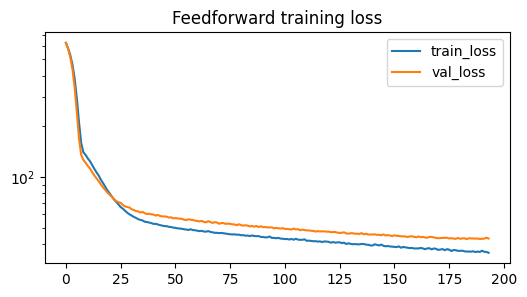

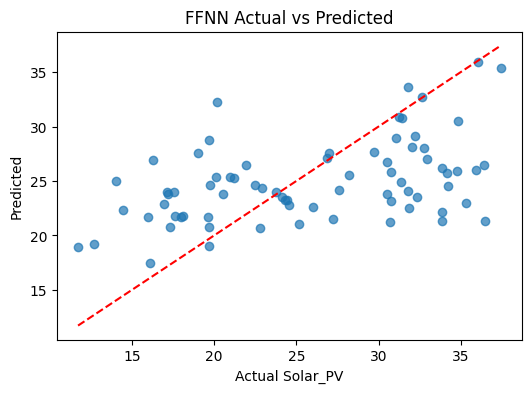

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
LSTM forecast (seq_len=7) — RMSE: 8.189, R2: -1.903
LSTM (binarized top25%) — Accuracy: 0.986
LSTM Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        72
           1       0.00      0.00      0.00         1

    accuracy                           0.99        73
   macro avg       0.49      0.50      0.50        73
weighted avg       0.97      0.99      0.98        73

LSTM Confusion matrix:
 [[72  0]
 [ 1  0]]


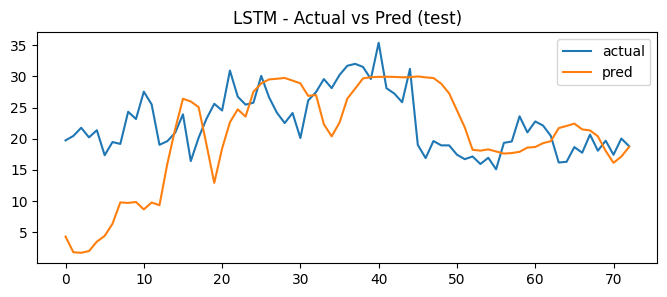

In [10]:
# Neural networks: Feedforward Dense regression and LSTM feedback (sequence) forecasting
# TensorFlow must be installed *and* the Jupyter kernel restarted before running this cell.
# Run the dedicated installation cell (the one with `%pip install -q tensorflow`), restart the kernel, then re-run this cell.
try:
    import tensorflow as tf
    print('TensorFlow version:', tf.__version__)
    try:
        gpus = tf.config.list_physical_devices('GPU')
        print('GPUs detected:', len(gpus))
    except Exception:
        pass
except ModuleNotFoundError:
    raise ModuleNotFoundError(
        "TensorFlow is not installed in this kernel. Run the installation cell containing '%pip install -q tensorflow' and restart the notebook kernel, or consider '%pip install -q tensorflow-cpu' if you do not have compatible GPU/drivers."
    )

from tensorflow.keras import models, layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix

# --- Feedforward Dense network (regression) ---
# Use base regression features for NN
features_nn = ['AvgTemperature','Humidity','Wind','Pressure','temp_dew_diff','temp_rolling_3','temp_lag_1']
X = df[features_nn].copy()
y = df['Solar_PV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler_ff = StandardScaler()
X_train_s = scaler_ff.fit_transform(X_train)
X_test_s = scaler_ff.transform(X_test)

model_ff = models.Sequential([
    layers.Input(shape=(X_train_s.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model_ff.compile(optimizer='adam', loss='mse')
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist = model_ff.fit(X_train_s, y_train, validation_split=0.2, epochs=200, batch_size=16, callbacks=[es], verbose=0)

y_pred_ff = model_ff.predict(X_test_s).ravel()
rmse_ff = mean_squared_error(y_test, y_pred_ff) ** 0.5
r2_ff = r2_score(y_test, y_pred_ff)
print(f"Feedforward NN — RMSE: {rmse_ff:.3f}, R2: {r2_ff:.3f}")

# Binarized metrics for FFNN (top 25% Solar_PV considered 'high')
th = df['Solar_PV'].quantile(0.75)
try:
    y_true_bin = (df.loc[X_test.index, 'Solar_PV'] > th).astype(int)
    y_pred_bin_ff = (y_pred_ff > th).astype(int)
    print(f"FFNN (binarized top25%) — Accuracy: {accuracy_score(y_true_bin, y_pred_bin_ff):.3f}")
    print('FFNN Classification report:\n', classification_report(y_true_bin, y_pred_bin_ff, zero_division=0))
    print('FFNN Confusion matrix:\n', confusion_matrix(y_true_bin, y_pred_bin_ff))
except Exception as e:
    print('Error computing FFNN binarized metrics:', e)

plt.figure(figsize=(6,3))
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend(); plt.title('Feedforward training loss')

plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_ff, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Solar_PV'); plt.ylabel('Predicted'); plt.title('FFNN Actual vs Predicted')
plt.show()

# --- Feedback (recurrent) network: LSTM forecasting ---
seq_len = 7
use_cols = ['Solar_PV','AvgTemperature']

data_arr = df[use_cols].values
X_seq = []
y_seq = []
for i in range(len(data_arr)-seq_len):
    X_seq.append(data_arr[i:i+seq_len])
    y_seq.append(data_arr[i+seq_len, 0])  # predict next day's Solar_PV
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# preserve time order for forecasting
n = len(X_seq)
train_n = int(n * 0.8)
X_train_seq = X_seq[:train_n]; y_train_seq = y_seq[:train_n]
X_test_seq = X_seq[train_n:]; y_test_seq = y_seq[train_n:]

# scale features
ns, nt, nf = X_train_seq.shape
X_train_flat = X_train_seq.reshape(-1, nf)
X_test_flat = X_test_seq.reshape(-1, nf)
scaler_seq = StandardScaler()
X_train_flat_s = scaler_seq.fit_transform(X_train_flat)
X_test_flat_s = scaler_seq.transform(X_test_flat)
X_train_seq_s = X_train_flat_s.reshape(ns, nt, nf)
X_test_seq_s = X_test_flat_s.reshape(X_test_seq.shape[0], nt, nf)

model_rnn = models.Sequential([
    layers.Input(shape=(nt, nf)),
    layers.LSTM(32),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])
model_rnn.compile(optimizer='adam', loss='mse')
es2 = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist2 = model_rnn.fit(X_train_seq_s, y_train_seq, validation_split=0.2, epochs=200, batch_size=16, callbacks=[es2], verbose=0)

y_pred_rnn = model_rnn.predict(X_test_seq_s).ravel()
rmse_rnn = mean_squared_error(y_test_seq, y_pred_rnn) ** 0.5
r2_rnn = r2_score(y_test_seq, y_pred_rnn)
print(f"LSTM forecast (seq_len={seq_len}) — RMSE: {rmse_rnn:.3f}, R2: {r2_rnn:.3f}")

# Binarized metrics for LSTM (top 25% threshold)
try:
    y_true_bin_l = (y_test_seq > th).astype(int)
    y_pred_bin_rnn = (y_pred_rnn > th).astype(int)
    print(f"LSTM (binarized top25%) — Accuracy: {accuracy_score(y_true_bin_l, y_pred_bin_rnn):.3f}")
    print('LSTM Classification report:\n', classification_report(y_true_bin_l, y_pred_bin_rnn, zero_division=0))
    print('LSTM Confusion matrix:\n', confusion_matrix(y_true_bin_l, y_pred_bin_rnn))
except Exception as e:
    print('Error computing LSTM binarized metrics:', e)

plt.figure(figsize=(8,3))
plt.plot(y_test_seq, label='actual')
plt.plot(y_pred_rnn, label='pred')
plt.legend(); plt.title('LSTM - Actual vs Pred (test)')
plt.show()



Explained variance ratio (components): [0.71577963 0.15619092 0.07996712 0.03791437 0.00640349]
Cumulative: [0.71577963 0.87197055 0.95193767 0.98985204 0.99625553]


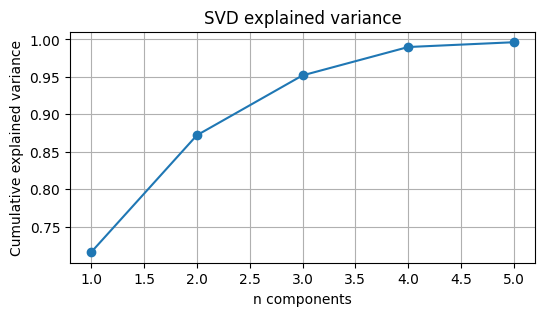


Component loadings:
                     PC1       PC2       PC3       PC4       PC5
AvgTemperature  0.431105  0.082834  0.167667  0.282361  0.688929
Humidity       -0.383556  0.265592  0.551757  0.108485  0.336359
Wind            0.067933  0.901998 -0.365233 -0.218210  0.026065
Pressure       -0.377231  0.045590 -0.442596  0.812179  0.005891
temp_dew_diff   0.394756 -0.255634 -0.488743 -0.067111  0.286315
temp_rolling_3  0.429160  0.140181  0.218562  0.305178 -0.093674
temp_lag_1      0.424387  0.148060  0.226996  0.321895 -0.566369

Reconstruction RMSE (standardized space) with k=2: 0.3578

Top contributing features to PC1:
AvgTemperature    0.431105
temp_rolling_3    0.429160
temp_lag_1        0.424387
temp_dew_diff     0.394756
Humidity          0.383556
Name: PC1, dtype: float64

Added svd_1 (and svd_2) to df


,svd_1,svd_2
0,0.362999,-0.155852
1,0.203751,-0.294156
2,-0.053106,-0.031216
3,-0.202869,-0.887605
4,0.675002,-1.746034


In [11]:
# Singular Value Decomposition (SVD) on base numeric features
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

features_svd = ['AvgTemperature','Humidity','Wind','Pressure','temp_dew_diff','temp_rolling_3','temp_lag_1']
X = df[features_svd].copy()

# Standardize
scaler_svd = StandardScaler()
X_s = scaler_svd.fit_transform(X)

n_comp = min(5, X_s.shape[1])
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd.fit(X_s)

print('Explained variance ratio (components):', svd.explained_variance_ratio_)
print('Cumulative:', svd.explained_variance_ratio_.cumsum())

# plot cumulative explained variance
plt.figure(figsize=(6,3))
plt.plot(range(1, n_comp+1), svd.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('n components'); plt.ylabel('Cumulative explained variance'); plt.title('SVD explained variance')
plt.grid(True); plt.show()

# Show component loadings
comp_df = pd.DataFrame(svd.components_.T, index=features_svd, columns=[f'PC{i+1}' for i in range(n_comp)])
print('\nComponent loadings:')
print(comp_df)

# Reconstruction using first k components
k = 2
components_k = svd.components_[:k]  # shape (k, n_features)
scores_k = X_s.dot(components_k.T)  # shape (n_samples, k)
X_recon_k = scores_k.dot(components_k)  # shape (n_samples, n_features)
rmse = mean_squared_error(X_s, X_recon_k) ** 0.5
print(f'\nReconstruction RMSE (standardized space) with k={k}: {rmse:.4f}')

# Top contributing features to PC1
top_features_pc1 = comp_df['PC1'].abs().sort_values(ascending=False)
print('\nTop contributing features to PC1:')
print(top_features_pc1.head(5))

# Add first two SVD components to dataframe for downstream use
svd_scores = svd.transform(X_s)
df['svd_1'] = svd_scores[:,0]
if n_comp > 1:
    df['svd_2'] = svd_scores[:,1]
print('\nAdded svd_1 (and svd_2) to df')
df[['svd_1','svd_2']].head()

In [18]:
df.head()

,Date,AvgTemperature,AvgDew,Humidity,Wind,Pressure,Solar_PV,year,month,day,...,is_weekend,temp_dew_diff,solar_log,temp_rolling_3,temp_lag_1,pressure_cat,solar_bin,is_solar_high,svd_1,svd_2
0,2021-04-01,80.0,29.4,16.7,10.9,29.2,31.214857,2021,4,1,...,False,50.6,3.472428,80.000000,80.0,medium,high,False,0.362999,-0.155852
1,2021-04-02,79.7,31.3,18.1,10.3,29.2,34.046000,2021,4,2,...,False,48.4,3.556661,79.850000,80.0,medium,high,True,0.203751,-0.294156
2,2021-04-03,77.2,30.4,20.7,10.8,29.2,34.187143,2021,4,3,...,True,46.8,3.560681,78.966667,79.7,medium,high,True,-0.053106,-0.031216
3,2021-04-04,73.1,25.1,17.3,9.0,29.2,31.442286,2021,4,4,...,True,48.0,3.479463,76.666667,77.2,medium,high,False,-0.202869,-0.887605
4,2021-04-05,85.6,26.3,11.8,7.6,29.2,31.606571,2021,4,5,...,False,59.3,3.484514,78.633333,73.1,medium,high,False,0.675002,-1.746034


In [23]:
df.head()

,Date,AvgTemperature,AvgDew,Humidity,Wind,Pressure,Solar_PV,year,month,day,...,solar_log,temp_rolling_3,temp_lag_1,pressure_cat,solar_bin,is_solar_high,svd_1,svd_2,temp_wind_pressure,temp_wind_pressure_z
0,2021-04-01,80.0,29.4,16.7,10.9,29.2,31.214857,2021,4,1,...,3.472428,80.000000,80.0,medium,high,False,0.362999,-0.155852,29.863013,0.093207
1,2021-04-02,79.7,31.3,18.1,10.3,29.2,34.046000,2021,4,2,...,3.556661,79.850000,80.0,medium,high,True,0.203751,-0.294156,28.113355,-0.094823
2,2021-04-03,77.2,30.4,20.7,10.8,29.2,34.187143,2021,4,3,...,3.560681,78.966667,79.7,medium,high,True,-0.053106,-0.031216,28.553424,-0.047530
3,2021-04-04,73.1,25.1,17.3,9.0,29.2,31.442286,2021,4,4,...,3.479463,76.666667,77.2,medium,high,False,-0.202869,-0.887605,22.530821,-0.694761
4,2021-04-05,85.6,26.3,11.8,7.6,29.2,31.606571,2021,4,5,...,3.484514,78.633333,73.1,medium,high,False,0.675002,-1.746034,22.279451,-0.721775
